# Photon ID Run 2 BDT classification X_noFF

In [1]:
import uproot
import numpy as np
import pandas as pd
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
#import mplhep as hep
#hep.style.use("ATLAS")

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

import joblib

import seaborn as sns

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/"
savedir = "/home/chardong/y_identification/Venv/save_plots/Py8_yj_jj_train_skim30/"
# Chemin pour enregistrer les fichiers pickle
save_path = '/home/chardong/y_identification/Venv/save_pkl/Fudge_Factor/'
#datadir = "/eos/user/m/mdelmast/Data/EGamma/PhotonID/Run2/"
savedirmodel = "/home/chardong/y_identification/Venv/BDT_model/skim30/"

In [3]:
totald = pd.read_pickle(datadir+"Fudge_Factor/Py8_yj_jj_mc16ade_pd122_train_w_skim_05_noFF.pkl")

In [4]:
columns = list(totald.columns)
columns

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_convRadius',
 'y_convType',
 'y_pt',
 'y_eta',
 'y_phi',
 'evt_mu',
 'y_jmin_dr',
 'y_IsTight',
 'y_IsLoose',
 'y_truth_pt',
 'y_truth_eta',
 'weight',
 'truth_label']

In [5]:
shower_shape_var = ['y_Reta',
                    'y_Rphi',
                    'y_weta2',
                    'y_fracs1',
                    'y_weta1',
                    'y_wtots1',
                    'y_Rhad',
                    'y_Rhad1',
                    'y_Eratio', 
                    'y_deltae']

conv_var = [ 'y_convRadius', 'y_convType']

kinem_var = ['y_pt', 'y_eta', 'y_phi']

#truth_var = ['y_truth_pt', 'y_truth_eta', 'y_truth_pdgId', 'y_truth_mother_pdgId' ]
truth_var = ['y_truth_pt', 'y_truth_eta' ]

discriminating_var = shower_shape_var + kinem_var + conv_var
discriminating_var

['y_Reta',
 'y_Rphi',
 'y_weta2',
 'y_fracs1',
 'y_weta1',
 'y_wtots1',
 'y_Rhad',
 'y_Rhad1',
 'y_Eratio',
 'y_deltae',
 'y_pt',
 'y_eta',
 'y_phi',
 'y_convRadius',
 'y_convType']

### Prepare inputs for training

* `discriminating_var` containes the features used in the training
* Weights are added Y column to be able to access them after splitting in train and test samples.
* `test_size` represents the proportion of the dataset to include in the test split

In [6]:
set(totald.columns)-set(discriminating_var)

{'evt_mu',
 'truth_label',
 'weight',
 'y_IsLoose',
 'y_IsTight',
 'y_jmin_dr',
 'y_truth_eta',
 'y_truth_pt'}

In [7]:
Y_var = ["truth_label",
         "weight",
         'y_IsTight',
         'y_IsLoose',
         'evt_mu', 
        ]

Y_var

['truth_label', 'weight', 'y_IsTight', 'y_IsLoose', 'evt_mu']

### Save X and Y datasets with relevant variables

* Adding truth variables to X for performance studies, will be removed after splitting

In [8]:
X = totald[discriminating_var+truth_var]
Y = totald[Y_var]

### Split dataset into train, validation and test samples

* Test dataset size: 20 %

In [9]:
x_train_val, x_test_XnoFF, y_train_val, y_test_XnoFF = train_test_split(X, Y, test_size=0.2, random_state=42)

### Split train + validation set into train and validation

* Train and validation are respectively 80% and 20% of 80% of total
* Save weights in separate arrays

In [10]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

In [11]:
weight_train = y_train["weight"]
weight_val   = y_val  ["weight"]
weight_test_XnoFF  = y_test_XnoFF ["weight"]

In [12]:
othervars_train = y_train[['evt_mu', 'y_IsLoose', 'y_IsTight']]
othervars_val   = y_val  [['evt_mu', 'y_IsLoose', 'y_IsTight']]
othervars_test  = y_test_XnoFF [['evt_mu', 'y_IsLoose', 'y_IsTight']]

In [13]:
truth_train = x_train[['y_truth_pt','y_truth_eta']]
truth_val   = x_val  [['y_truth_pt','y_truth_eta']]
truth_test  = x_test_XnoFF [['y_truth_pt','y_truth_eta']]

In [14]:
truth_var_drop = list(set(y_train.columns)-{'truth_label'})
truth_var_drop

['y_IsTight', 'y_IsLoose', 'evt_mu', 'weight']

In [15]:
y_train = y_train.drop(truth_var_drop, axis=1)
y_test_XnoFF  = y_test_XnoFF.drop(truth_var_drop, axis=1)
y_val   = y_val.drop(truth_var_drop, axis=1)

In [16]:
x_train = x_train.drop(truth_var, axis=1)
x_test_XnoFF  = x_test_XnoFF.drop(truth_var, axis=1)
x_val   = x_val.drop(truth_var, axis=1)

In [17]:
# Sauvegarder les DataFrames et Series en fichiers pickle
x_test_XnoFF.to_pickle(save_path + 'x_test_y_test_weight_test/x_test_XnoFF.pkl')
y_test_XnoFF.to_pickle(save_path + 'x_test_y_test_weight_test/y_test_XnoFF.pkl')
weight_test_XnoFF.to_pickle(save_path + 'x_test_y_test_weight_test/weight_test_XnoFF.pkl')

In [18]:
print('TRAINING   size = {:8d}'.format(len(y_train)))
print('TEST       size = {:8d}'.format(len(y_test_XnoFF)))
print('VALIDATION size = {:8d}'.format(len(y_val)))

TRAINING   size =  1863667
TEST       size =   582396
VALIDATION size =   465917


In [19]:
print('Number of signal events in test sample     :', len(y_test_XnoFF.query('truth_label == True')))
print('Number of background events in test sample :', len(y_test_XnoFF.query('truth_label == False')))

Number of signal events in test sample     : 388858
Number of background events in test sample : 193538


In [20]:
y_train = np.ravel(y_train)
y_val = np.ravel(y_val)

# BDT training

In [21]:
# Loading model from file
model = joblib.load(savedirmodel+"LGBMClassifier_model_hard_no_loose_lr0.05_35_skim30.pkl")

### Feature importance

Text(0.5, 1.0, 'Metric during training')

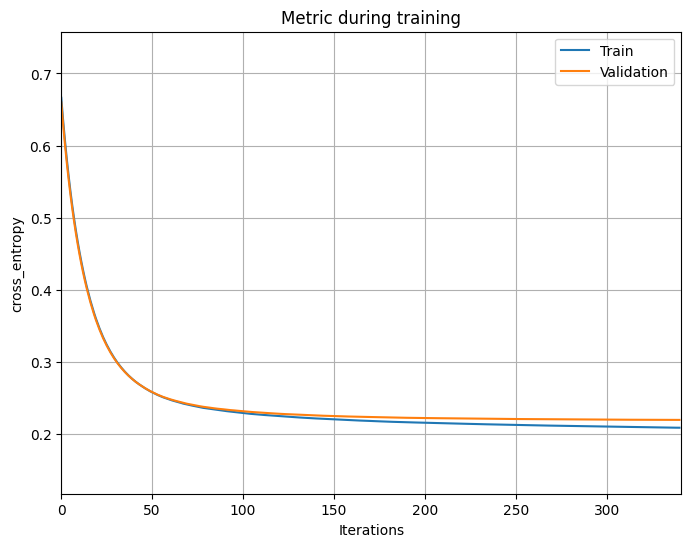

In [22]:
# Cross-entropy evolution during training
lgb.plot_metric(model, figsize=(8,6))
plt.title('Metric during training')
#plt.savefig(savedir+'metric_lr_0.09_35_skim30.pdf')

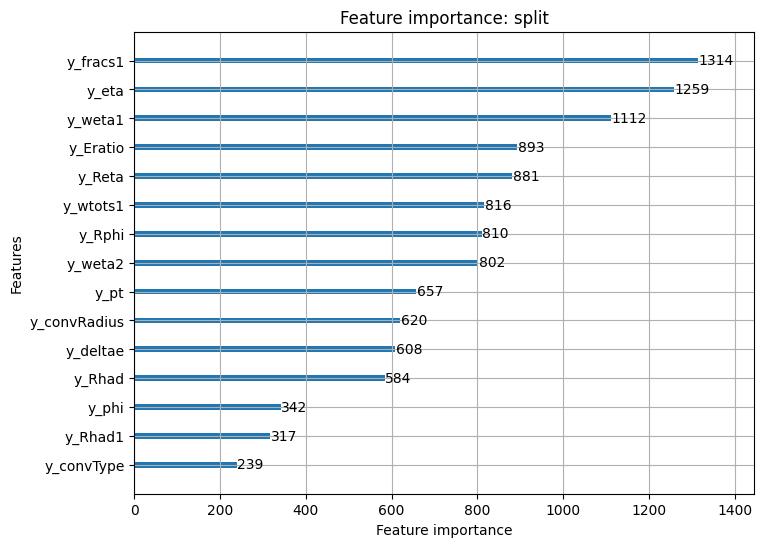

In [23]:
# Feature importance: Numbers of times the feature is used in a model
lgb.plot_importance(model, importance_type='split', figsize=(8,6))
plt.title('Feature importance: split')
#plt.savefig(savedir+'feature_split_lr_0.09_35_skim30.pdf')
plt.show()

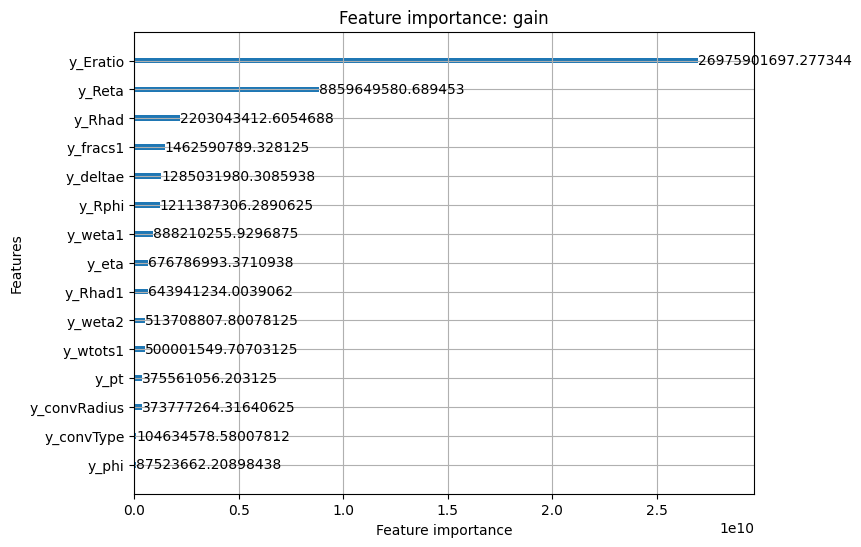

In [24]:
lgb.plot_importance(model, importance_type='gain', precision = None, figsize=(8,6))
plt.title('Feature importance: gain')
#plt.savefig(savedir+'feature_gain_lr_0.09_35_skim30.pdf')
plt.show()

### Make predictions for test sample, add signal and background scores

In [25]:
y_pred_prob_test = model.predict_proba(x_test_XnoFF)

df_pred_test = pd.DataFrame(y_pred_prob_test, columns=["background_score", "signal_score"])
df_pred_test.reset_index(inplace=True, drop=True)

In [26]:
y_test_XnoFF = pd.DataFrame(y_test_XnoFF)
y_test_XnoFF.reset_index(inplace=True, drop=True)

truth_test.reset_index(inplace=True, drop=True)

othervars_test.reset_index(inplace=True, drop=True)

df_test_vars = x_test_XnoFF[kinem_var + conv_var]
df_test_vars.reset_index(inplace=True, drop=True)

weight_test_XnoFF = pd.DataFrame(weight_test_XnoFF)
weight_test_XnoFF.reset_index(inplace=True, drop=True)

In [27]:
df_test = pd.concat([df_test_vars,
                     weight_test_XnoFF,
                     y_test_XnoFF,
                     othervars_test,
                     truth_test,
                     df_pred_test,
                    ], axis=1, join='inner', ignore_index=True)

In [28]:
col_names = list(df_test_vars.columns) + \
            list(weight_test_XnoFF.columns) + \
            list(y_test_XnoFF.columns) + \
            list(othervars_test.columns) + \
            list(truth_test.columns) + \
            list(df_pred_test.columns)
df_test.columns = col_names

In [29]:
df_test

,y_pt,y_eta,y_phi,y_convRadius,y_convType,weight,truth_label,evt_mu,y_IsLoose,y_IsTight,y_truth_pt,y_truth_eta,background_score,signal_score
0,79.908234,-0.139806,1.488639,9999.000000,0,45.165662,1.0,26.500000,True,True,80.455193,-0.140035,0.016398,0.983602
1,147.032104,-0.645639,-0.750850,9999.000000,0,3.779654,1.0,42.500000,True,True,145.044418,-0.646035,0.045226,0.954774
2,182.470413,-1.591981,2.985178,9999.000000,0,4.452168,1.0,22.500000,True,True,185.194641,-1.605502,0.016819,0.983181
3,79.366753,-0.210481,0.493208,9999.000000,0,30.423005,1.0,10.490000,True,True,79.574791,-0.210434,0.041379,0.958621
4,24.088655,0.356945,-2.202396,9999.000000,0,1788.282546,0.0,25.500000,True,False,10.192179,0.352569,0.950430,0.049570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582391,149.600891,1.239144,1.418191,9999.000000,0,2.621104,1.0,48.500000,True,True,151.757919,1.238922,0.051084,0.948916
582392,842.184021,0.659669,-2.234954,9999.000000,0,0.009850,1.0,28.490000,True,True,826.824463,0.659969,0.026405,0.973595
582393,701.007874,-0.639603,-1.084347,295.783875,1,0.016549,1.0,32.500000,True,True,710.850159,-0.639870,0.031683,0.968317
582394,273.713104,-1.289090,0.702649,9999.000000,0,5.006003,1.0,14.490000,True,True,271.662262,-1.288384,0.017680,0.982320


In [30]:
df_test.to_pickle(datadir+"/df_test_sample_hard_scattering/Fudge_Factor/test_sample_hard_scattering_skim05_XnoFF.pkl")

### BDT output

The BDT output has two columns: for each event a score (probability) to belong to class 0 or class 1  (here they are called `background_class` and `signal_class` ) is assigned.

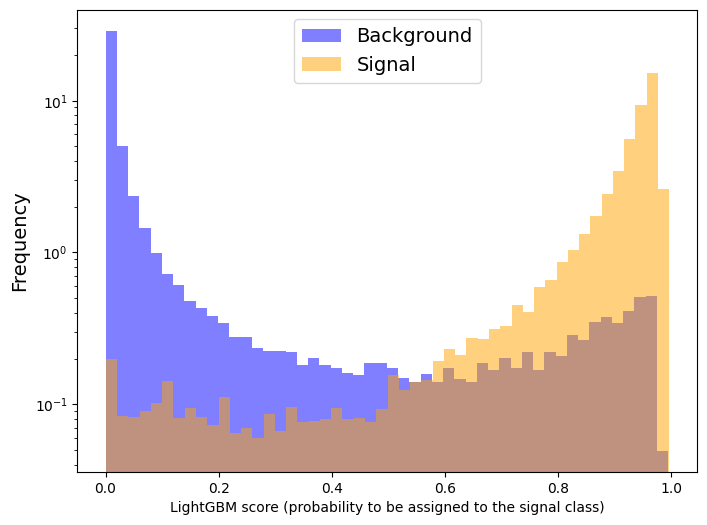

In [31]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(df_test[(df_test["truth_label"]==0 )]["signal_score"],
         weights = df_test[(df_test["truth_label"]==0 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5, 
         histtype = 'stepfilled', label='Background', color = 'b')

plt.hist(df_test[(df_test["truth_label"]==1 )]["signal_score"],
         weights = df_test[(df_test["truth_label"]==1 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5,
         histtype = 'stepfilled', label='Signal', color = 'orange')

plt.ylabel('Frequency', fontsize = 14)

plt.legend(loc='upper center', fontsize = 14)
plt.gca().set(xlabel="LightGBM score (probability to be assigned to the signal class)")

#plt.savefig(savedir+'score_lr_0.09_35_skim30.pdf')
plt.show()

### ROC curve

1) compute signal and background efficiencies for "official" cut-based Tight selection

In [32]:
s_tot = sum( df_test[(df_test["truth_label"] == 1)]["weight"] )
s_selected = sum( df_test[(df_test["truth_label"] == 1) & (df_test['y_IsTight'].values)]["weight"] )
s_eff = s_selected / s_tot

b_tot = sum( df_test[(df_test["truth_label"] == 0)]["weight"] )
b_selected = sum( df_test[(df_test["truth_label"] == 0) & (df_test['y_IsTight'].values)]["weight"] )
b_eff = b_selected / b_tot

In [33]:
print(f"Number of signal events                   = {s_tot:12.0f}")
print(f"Number of signal events passing Tight     = {s_selected:12.0f}")
print(f"Signal efficiency of cut-based Tight      = {100.*s_selected/s_tot:11.2f}%" )
print()
print(f"Number of background events               = {b_tot:12.0f}")
print(f"Number of background events passing Tight = {b_selected:12.0f}")
print(f"Background efficiency of cut-based Tight  = {100.*b_selected/b_tot:11.2f}%" )
print(f"Background rejection of cut-based Tight   = {100.*(1-b_selected/b_tot):11.2f}%" )

Number of signal events                   =    118814388
Number of signal events passing Tight     =     95309878
Signal efficiency of cut-based Tight      =       80.22%

Number of background events               =    120463400
Number of background events passing Tight =      7732905
Background efficiency of cut-based Tight  =        6.42%
Background rejection of cut-based Tight   =       93.58%


2) Plot ROC curve of trained BDT with weighted events, compare to current cut-based Tight selection 

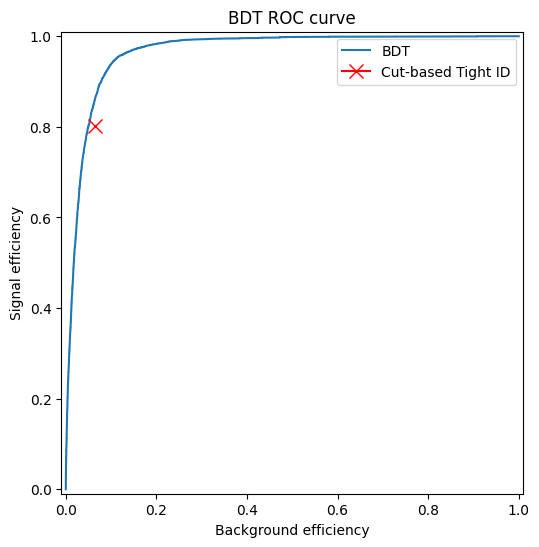

In [34]:
fig, ax = plt.subplots(figsize=(8,6))

mod_disp = RocCurveDisplay.from_estimator(model, x_test_XnoFF, y_test_XnoFF, sample_weight=weight_test_XnoFF, 
                                          label="BDT", ax=ax) 

plt.plot(b_eff, s_eff, marker="x", markersize=10, color="red", label = 'Cut-based Tight ID')

plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')

#plt.xlim([0.0, 0.15])
#plt.ylim([0.65, 1.0])
#plt.title('BDT ROC curve - zoom')

plt.title('BDT ROC curve')
plt.legend()

#plt.savefig(savedir+'ROC_lr_0.05_35_weight_skim30.pdf')
plt.show()

### Correlation between input variables

In [35]:
#x_train_sel = x_train.query('y_wtots1 >- 800 & y_weta1 > -800')
#x_train_sel.reset_index(inplace=True, drop=True)

In [36]:
corr = x_train.corr()

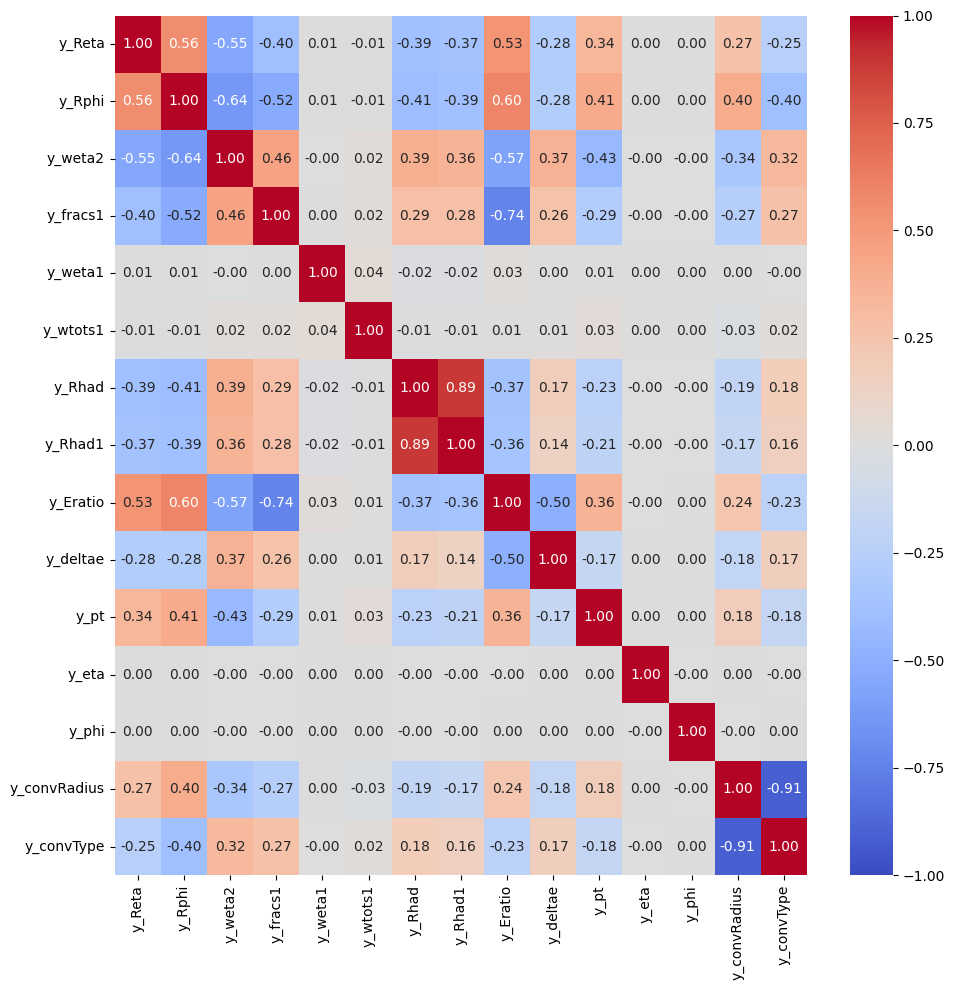

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
#plt.savefig(savedir+'correlations_train_sample_all_skim30.pdf')
plt.show()

In [38]:
#corr_sig = x_train[(y_train==1)].corr()
#corr_bkg = x_train[(y_train==0)].corr()